In [1]:
import pickle
import os

FOLDER = os.getcwd() + "/6_ovals"

with open(FOLDER+'/ori.pkl', 'rb') as file:   
    ori = pickle.load(file)
with open(FOLDER+'/mask.pkl', 'rb') as file:   
    mask = pickle.load(file)
with open(FOLDER+'/out.pkl', 'rb') as file:   
    out = pickle.load(file)
with open(FOLDER+'/psf.pkl', 'rb') as file:   
    original_psf = pickle.load(file)


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.rcParams['figure.figsize'] = [15, 5]
import math
import numpy as np
import random
import time
from utils import *
from SyMBac.PSF import PSF_generator

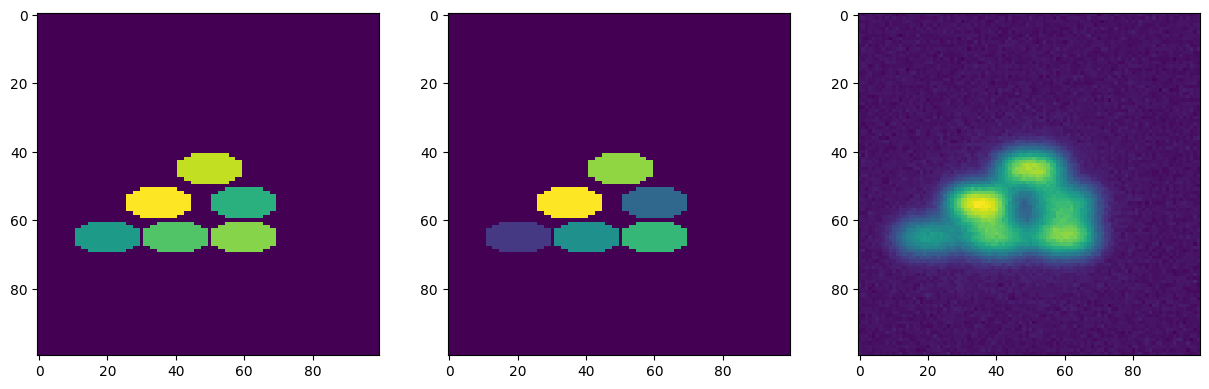

In [3]:
f, axarr = plt.subplots(1,3)
axarr[0].imshow(ori)
axarr[1].imshow(mask)
axarr[2].imshow(out)
plt.show()

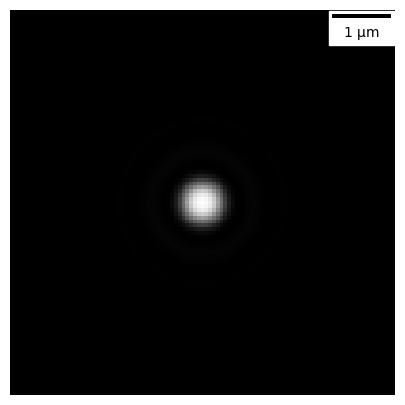

[[1.22360606e-04 1.18749290e-04 9.83829153e-05 ... 9.83829153e-05
  1.18749290e-04 1.22360606e-04]
 [1.18749290e-04 9.78159063e-05 6.57887630e-05 ... 6.57887630e-05
  9.78159063e-05 1.18749290e-04]
 [9.83829153e-05 6.57887630e-05 3.17538820e-05 ... 3.17538820e-05
  6.57887630e-05 9.83829153e-05]
 ...
 [9.83829153e-05 6.57887630e-05 3.17538820e-05 ... 3.17538820e-05
  6.57887630e-05 9.83829153e-05]
 [1.18749290e-04 9.78159063e-05 6.57887630e-05 ... 6.57887630e-05
  9.78159063e-05 1.18749290e-04]
 [1.22360606e-04 1.18749290e-04 9.83829153e-05 ... 9.83829153e-05
  1.18749290e-04 1.22360606e-04]]


/home/boomalope/symbac/symbac/lib/python3.8/site-packages/SyMBac/PSF.py:178: RuntimeWarning: invalid value encountered in divide
  PSF = (2 * jv(1, rr) / (rr)) ** 2


In [4]:
my_kernel = PSF_generator(
    radius = 50, 
    wavelength = 0.75, 
    NA = 1.0, 
    n = 1.4, 
    resize_amount = 1, 
    pix_mic_conv = 0.065, 
    apo_sigma = 8, 
    mode="simple fluo", 
    condenser = "Ph3",
    offset = 0
)
my_kernel.calculate_PSF()
my_kernel.plot_PSF()
psf = my_kernel.get_fluorescence_kernel(my_kernel.wavelength,my_kernel.NA,my_kernel.n,my_kernel.radius,my_kernel.scale)
print(psf)

In [5]:
randomPts = 0
originalOutput = out
sourcePts = GetSourcePts(mask)
recoveredImage = InverseMatrix(out, mask, sourcePts, learningRate = 1, psf=psf)

[0.8333333333333334, 1.0, 0.3333333333333333, 0.16666666666666666, 0.5, 0.6666666666666666]
[[0.91392921]
 [1.        ]
 [0.65813508]
 [0.57563246]
 [0.74296086]
 [0.83019929]]


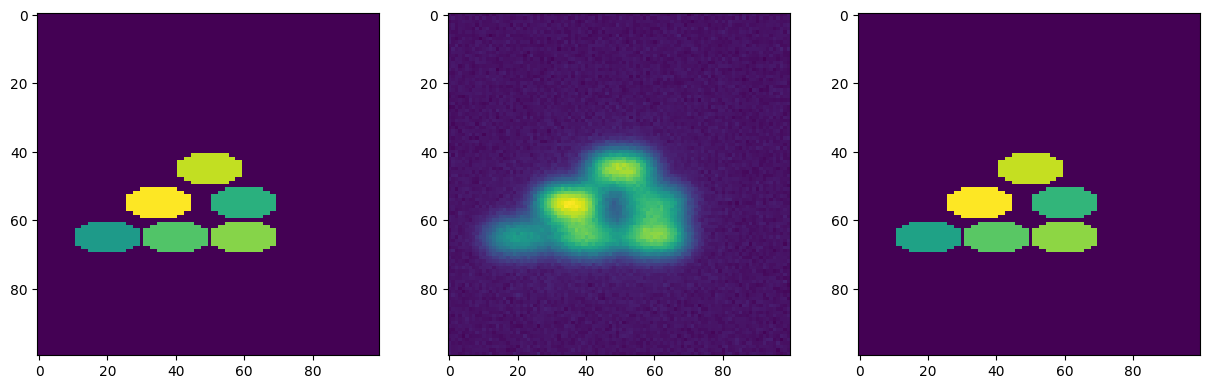

In [6]:
f, axarr = plt.subplots(1,3)
axarr[0].imshow(ori)
axarr[1].imshow(out)
axarr[2].imshow(recoveredImage)
plt.show()

array([[1.        , 0.99997499],
       [0.99997499, 1.        ]])

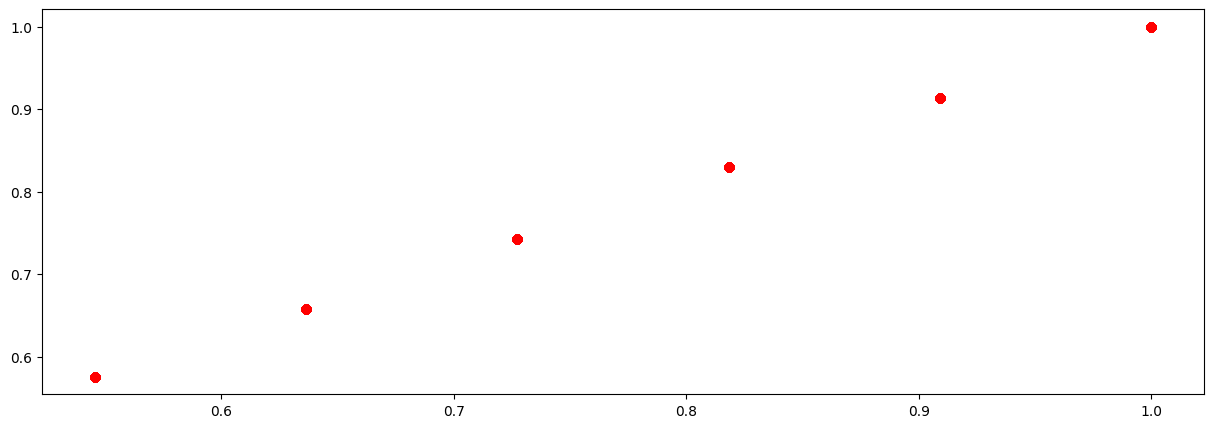

In [7]:
original_intensity = []
custom_intensity = []


for x in sourcePts:
    original_intensity.append(ori[x[0],x[1]])
    custom_intensity.append(recoveredImage[x[0],x[1]])

plt.plot(original_intensity,custom_intensity,'ro')

#Calculate correlation coefficient
np.corrcoef(original_intensity,custom_intensity)